<a href="https://colab.research.google.com/github/paulynamagana/afdb-analysis-tools/blob/main/notebooks/alphamissense_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the Colab notebook

Provide input: You'll need to provide:
* A list of UniProt IDs.


1. To run a code cell, click on the cell to select it. You will notice a play button (▶️) on the left side of the cell. Click on the play button or press Shift+Enter to run the code in the selected cell.
2. The code will start executing, and you will see the output, if any, displayed below the code cell.
3. Move to the next code cell and repeat steps 2 and 3 until you have executed all the desired code cells in sequence.
4. The currently running step is indicated by a circle with a stop sign next to it. If you need to stop or interrupt the execution of a code cell, you can click on the stop button (■) located next to the play button.


In [11]:
import logging
import os
import sys
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from ipywidgets import interact, IntSlider, Button, HBox, VBox, Layout  # for save button


# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


def fetch_AFDB_data(uniprot_accession):
    """Fetches data from the AlphaFold Database API.

    Args:
        uniprot_accession (str): The UniProt accession code.

    Returns:
        dict or None: The JSON result, or None on error.
    """
    url = f"https://alphafold.ebi.ac.uk/api/prediction/{uniprot_accession}"
    try:
        logging.info(f"Fetching data for {uniprot_accession}")
        response = requests.get(url, timeout=10)  # Added timeout
        response.raise_for_status()
        logging.info(f"Successfully retrieved data for {uniprot_accession}")
        return response.json()

    except requests.exceptions.RequestException as e:
        logging.error(f"Error retrieving data for {uniprot_accession}: {e}")
        return None


def extract_alpha_missense_url(data):
    """Extracts the AlphaMissense URL from the API data.

    Args:
        data (dict): The JSON data from the API.

    Returns:
        str: The AlphaMissense URL, or an error message.
    """
    if data and isinstance(data, list) and len(data) > 0:
        logging.info(f"Retrieving AlphaMissense data URL")
        return data[0].get('amAnnotationsUrl', "No AlphaMissense data for this protein.")
    else:
        return "Error: No data provided or invalid format."


def extract_pdb_url(data):
    """Extracts the PDB URL from the API data.

    Args:
        data (dict): The JSON data from the API.

    Returns:
        str: The PDB url, or an error message.
    """
    if data and isinstance(data, list) and len(data) > 0:
        logging.info(f"Retrieving PDB file URL")
        return data[0].get('pdbUrl', "Failed to retrieve PDB URL.")
    else:
        return "Error: No data provided or invalid format."


def extract_am_data(am_url):
    """Extracts AlphaMissense data from the URL and saves it as a CSV file.

    Args:
        am_url (str): URL to the AlphaMissense data CSV.

    Returns:
        pandas.DataFrame or None: The AlphaMissense data, or None on error.
    """
    try:
        logging.info(f"Reading AlphaMissense data from {am_url}")
        am_file = pd.read_csv(am_url)
    except Exception as e:
        logging.error(f"Error reading AlphaMissense file: {e}")
        return None

    reference_aa = am_file["protein_variant"].str.extract(r'^([A-Z])')[0]
    alternative_aa = am_file["protein_variant"].str.extract('([A-Z])$')[0]
    residue_number = pd.to_numeric(am_file["protein_variant"].str.extract(r'([0-9]+)')[0])
    pathogenicity_score = pd.to_numeric(am_file['am_pathogenicity'])

    am_data = pd.DataFrame({
        'reference_aa': reference_aa,
        'residue_number': residue_number,
        "alternative_aa": alternative_aa,
        "pathogenicity_score": pathogenicity_score
    })

    output_directory = "data_output"
    ensure_directory_exists(output_directory)
    output_filename = os.path.basename(am_url)
    output_file = os.path.join(output_directory, output_filename)

    try:
        am_data.to_csv(output_file, index=False)
        logging.info(f"AlphaMissense data saved to: {output_filename}")
    except Exception as e:
        logging.error(f"Error saving AlphaMissense data: {e}")

    return am_data


def calculate_average_pathogenicity(am_data):
    """Calculates average pathogenicity scores per residue from AlphaMissense data.

    Args:
        am_data (pandas.DataFrame): DataFrame containing AlphaMissense data.

    Returns:
        numpy.ndarray or None: Array of average pathogenicity scores, or None on error.
    """
    if am_data is None:
        logging.error("No AlphaMissense data available, check if UniProt has AlphaMissense data.")
        return None

    grouped = am_data.groupby(['residue_number'])['pathogenicity_score'].mean().reset_index()
    max_residue_number = grouped['residue_number'].max()
    average_scores = np.full(max_residue_number + 1, np.nan)

    for _, row in grouped.iterrows():
        residue_number = int(row['residue_number'])
        average_scores[residue_number] = round(row['pathogenicity_score'], 4)
    return average_scores


def modify_pdb_with_am_data(pdb_url, average_scores_file):
    """Modifies a PDB file with AlphaMissense pathogenicity scores.

    Args:
        pdb_url (str): URL to the PDB file.
        average_scores_file (numpy.ndarray): Array of average pathogenicity scores.
    """
    if not pdb_url:
        logging.error("PDB URL is not provided.")
        return

    try:
        logging.info("Retrieving PDB file")
        response = requests.get(pdb_url, timeout=10)
        response.raise_for_status()
        pdb_content = response.text.splitlines()
    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to retrieve the PDB file: {e}")
        return

    output_directory = "data_output"
    ensure_directory_exists(output_directory)

    base_filename = os.path.basename(pdb_url)
    output_filename = f"AM_scores_{base_filename}"
    output_file = os.path.join(output_directory, output_filename)

    try:
        logging.info(f"Writing modified PDB data to: {output_file}")
        with open(output_file, "w", encoding="utf-8") as out_file:
            for line in pdb_content:
                if line.startswith("ATOM") or line.startswith("HETATM"):
                    residue_number = int(line[22:26].strip())
                    if residue_number < len(average_scores_file) and not np.isnan(average_scores_file[residue_number]):
                        value = average_scores_file[residue_number]
                        value_str = f"{value:.2f}"
                        while len(value_str) < 6:
                            value_str = " " + value_str
                        edit_line = line[:60] + value_str + line[66:]
                        out_file.write(edit_line + '\n')
                    else:
                        out_file.write(line + '\n')
                else:
                    out_file.write(line + '\n')
    except IOError as e:
        logging.error(f"Error writing to file: {e}")


def extract_pathogenicity_and_plddt(am_file_path, pdb_file_url):
    """Extracts pathogenicity and pLDDT scores from AM and PDB files.

    Args:
        am_file_path (str): Path to the AM file.
        pdb_file_url (str): URL to the PDB file.

    Returns:
        tuple: Lists of pathogenicity and pLDDT scores.
    """
    pathogenicity_scores = {}
    plddt_scores = {}

    try:
        with open(am_file_path, "r") as f:
            am_pdb = f.read()

        for line in am_pdb.splitlines():
            if line.startswith(("ATOM", "HETATM")):
                residue_number = int(line[22:26].strip())
                score = float(line[60:66].strip())
                pathogenicity_scores.setdefault(residue_number, []).append(score)

        pathogenicity_scores = {
            residue: sum(scores) / len(scores) for residue, scores in pathogenicity_scores.items()
        }

    except FileNotFoundError:
        logging.error(f"AM file not found: {am_file_path}")
    except ValueError:
        logging.error("Error parsing pathogenicity scores in AM file.")

    if pdb_file_url:
        try:
            response = requests.get(pdb_file_url, timeout=10)
            response.raise_for_status()
            pdb_content = response.text.splitlines()

            for line in pdb_content:
                if line.startswith(("ATOM", "HETATM")):
                    residue_number = int(line[22:26].strip())
                    score = float(line[60:66].strip())
                    plddt_scores.setdefault(residue_number, []).append(score)

            plddt_scores = {
                residue: sum(scores) / len(scores) for residue, scores in plddt_scores.items()
            }

        except requests.exceptions.RequestException as e:
            logging.error(f"Error fetching PDB data: {e}")
        except ValueError:
            logging.error("Error parsing pLDDT scores in PDB file.")

    residues = sorted(set(pathogenicity_scores.keys()).union(set(plddt_scores.keys())))
    pathogenicity_scores_list = [pathogenicity_scores.get(residue, None) for residue in residues]
    plddt_scores_list = [plddt_scores.get(residue, None) for residue in residues]

    return pathogenicity_scores_list, plddt_scores_list




def plot_scores(pathogenicity_scores, plddt_scores, uniprot_id):
    """
    Plots pathogenicity and rescaled pLDDT scores against residue number using Seaborn.

    Args:
        pathogenicity_scores (list): List of pathogenicity scores.
        plddt_scores (list): List of pLDDT scores.
    """

    # Rescale pLDDT scores from 0-100 to 0-1
    plddt_rescaled = [score / 100 for score in plddt_scores]

    # Create a DataFrame for easy plotting with Seaborn
    data = {
        'Residue number': range(1, len(pathogenicity_scores) + 1),
        'Average pathogenicity': pathogenicity_scores,
        'pLDDT (rescaled)': plddt_rescaled
    }
    df = pd.DataFrame(data)

    # Create line plots with Seaborn
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    sns.lineplot(x='Residue number', y='Average pathogenicity', data=df, label='Average AM score')
    sns.lineplot(x='Residue number', y='pLDDT (rescaled)', data=df, label='pLDDT (rescaled)')

    # Add labels, title, and legend
    plt.xlabel('Residue number')
    plt.ylabel('Score')
    plt.title(f'Average AM and pLDDT scores per position ({uniprot_id})')
    plt.legend()
    plt.xlim(1, len(pathogenicity_scores))

    if len(pathogenicity_scores) > 200:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(100))  # Set marks every 100 residues
    else:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(50))  # Set marks every 100 residues

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=5)

    plt.grid(axis='y', linestyle='--')  # Optional grid

        # Save the plot to a file
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leaves space below for the legend

        # Save the plot to a file
    output_directory = "data_output"
    output_file = os.path.join(output_directory, f"graph_plDDT-AM-score_{uniprot_id}.png")
    plt.savefig(output_file) #save file

    # Show the plot
    plt.show()
    plt.close()


def plot_am_heatmap(am_data, uniprot_id):
    """
    Plots a heatmap for the AlphaMissense data with reference residues on x and alternative_aa on y axis
    Colour coded following the original colours from the AlphaFold Database, see: https://alphafold.ebi.ac.uk/entry/Q5VSL9
    """

    #custom palette
    def create_custom_colormap():
        cdict = {
            'red': [
                (0.0, 56/255, 56/255),
                (0.34, 204/255, 204/255),
                (0.464, 204/255, 204/255),
                (1.0, 165/255, 165/255)
            ],
            'green': [
                (0.0, 83/255, 83/255),
                (0.34, 204/255, 204/255),
                (0.464, 204/255, 204/255),
                (1.0, 13/255, 13/255)
            ],
            'blue': [
                (0.0, 163/255, 163/255),
                (0.34, 204/255, 204/255),
                (0.464, 204/255, 204/255),
                (1.0, 18/255, 18/255)
            ]
        }
        return LinearSegmentedColormap('CustomMap', segmentdata=cdict)

    # custom colormap
    custom_cmap = create_custom_colormap()

    # pivot table
    pivot_table = am_data.pivot_table(values='pathogenicity_score', index='alternative_aa', columns='reference_aa', aggfunc='mean')
    pivot_table = pd.pivot_table(am_data, values='pathogenicity_score',
    index='alternative_aa', columns='residue_number')

    #custom_order = ["R", "H", "K", "D", "E", "S", "T", "N", "Q", "C", "P", "A", "V", "I", "L", "M", "G", "F","Y","W"]

    # Reindex the pivot table
    #pivot_table = pivot_table.reindex(custom_order)

    plt.figure(figsize=(14, 6))

    ax = sns.heatmap(pivot_table, cmap=custom_cmap, vmin=0, vmax=1,
    cbar_kws={'label': 'AlphaMissense score'}) # Limits for the color scale

    ax.set_xlabel('Residue Number')
    ax.set_ylabel('Alternative Amino Acid')
    plt.title(f'AlphaMissense Pathogenicity Heatmap ({uniprot_id})')

    xticks = range(0, pivot_table.shape[1], 50)
    ax.set_xticks(xticks)
    ax.set_xticklabels(pivot_table.columns[xticks])
    ax.set_facecolor('black') #Set background black for matching AA
    plt.yticks(rotation = 0)

    cbar = ax.collections[0].colorbar
    cbar.set_ticks([i / 10.0 for i in range(11)])
    cbar.set_ticklabels([f'{i / 10.0:.1f}' for i in range(11)])
    plt.tight_layout()


    # Save the plot to a file
    output_directory = "data_output"
    ensure_directory_exists(output_directory)

    output_file = os.path.join(output_directory, f"AM_heatmap_{uniprot_id}.png")
    plt.savefig(output_file) #save file
    plt.show() # Show plot

    plt.close() # Close the figure after saving to free up resources

def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        logging.info(f"Created directory: {directory}")



#@title <font color='#e59454'>Retrieve data from AlphaFold Database
sys.path.insert(1, '/content/AFDB_scripts')

uniprot_id =  "Q9Y5P2" #@param {type:"string"}

# Step 1: Split the input string by commas and strip whitespace
uniprot_ids = [accession.strip() for accession in uniprot_id.split(',')]

output_directory = "data_output"
ensure_directory_exists(output_directory)


Sucessfully retrieved data for Q9Y5P2


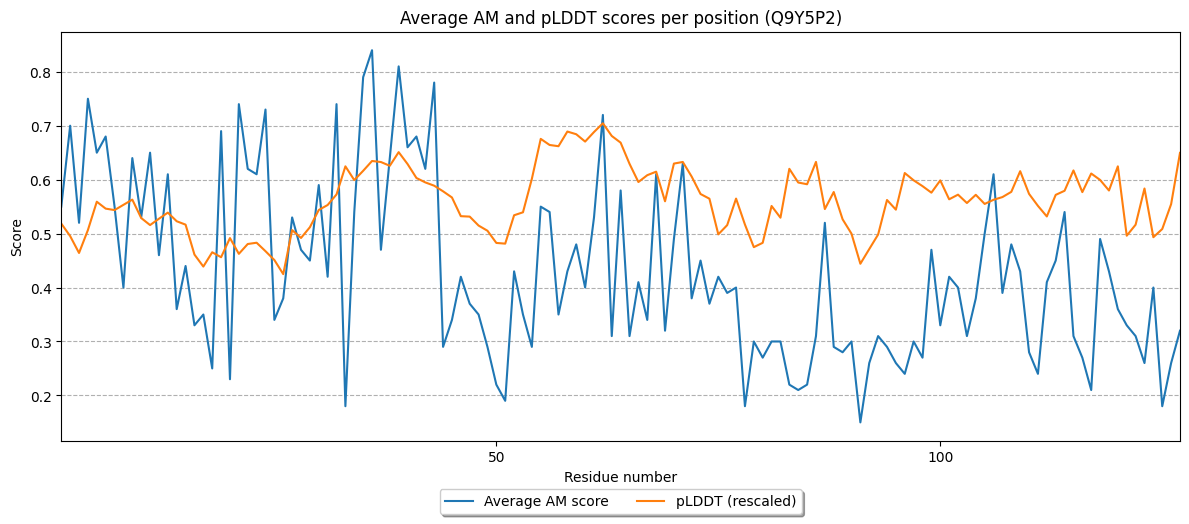

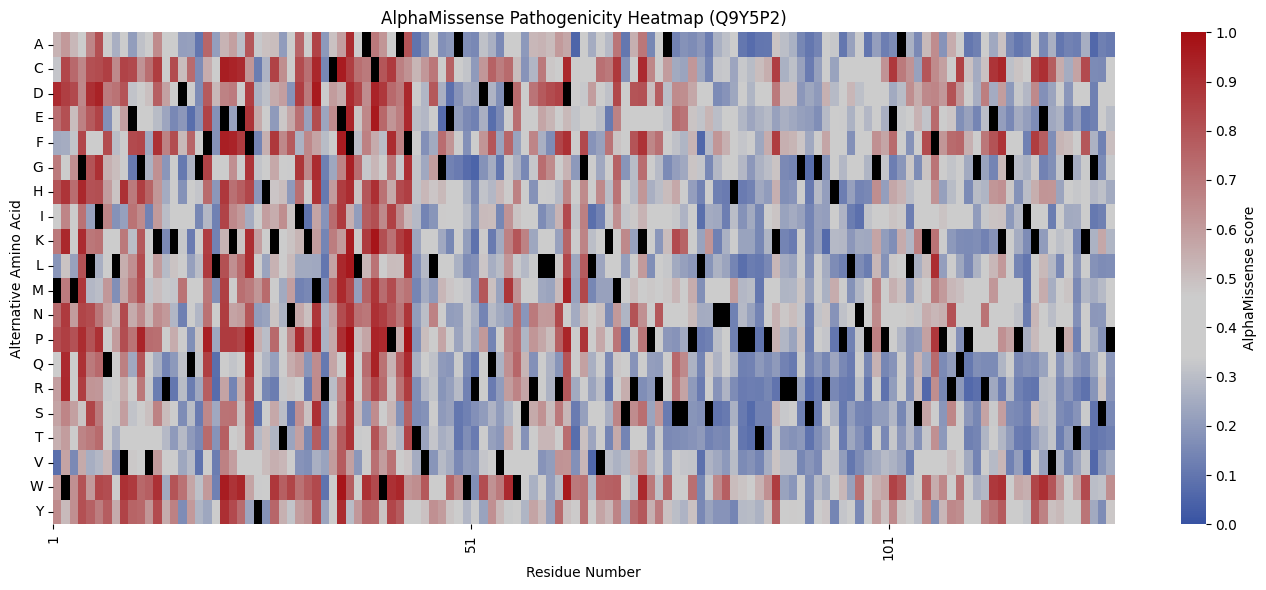

In [12]:
#@title <font color='#e59454'>Show plddt vs average AlphaMissense plots & AlphaMissense heatmap

for uniprot_id in uniprot_ids:
  alphafold_data = fetch_AFDB_data(uniprot_id)
  if alphafold_data:
    am_data=extract_am_data(am_url=extract_alpha_missense_url(alphafold_data))
    pdb_data_url = extract_pdb_url(alphafold_data)
    modify_pdb_with_am_data(pdb_data_url, average_scores_file=calculate_average_pathogenicity(am_data))
    file_path= f"data_output/AM_scores_AF-{uniprot_id}-F1-model_v4.pdb"
    pathogenicity_scores, plddt_scores = extract_pathogenicity_and_plddt(file_path, pdb_data_url)

    print(f"Sucessfully retrieved data for {uniprot_id}")
    plot_scores(pathogenicity_scores, plddt_scores, uniprot_id)
    plot_am_heatmap(am_data, uniprot_id)

In [15]:
#@title <font color='#e59454'>Show zoomed heatmap
#@markdown In this part of the Google Colab, you will be able to choose the UniProt ID, make sure you have run the previous code blocks to retrieve the data.


def ensure_directory_exists(directory):
    """Ensures that the specified directory exists.

    Args:
        directory (str): The path to the directory.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
        logging.info(f"Created directory: {directory}")


def save_am_data(am_data, uniprot_id, output_directory):
    """Saves AlphaMissense data to a CSV file.

    Args:
        am_data (pandas.DataFrame): The AlphaMissense data.
        uniprot_id (str): The UniProt ID.
        output_directory (str): The directory to save the file.
    """
    output_file = os.path.join(output_directory, f"AM_data_{uniprot_id}.csv")
    am_data.to_csv(output_file, index=False)
    logging.info(f"Saved AM data for {uniprot_id} to {output_file}")


def load_am_data(uniprot_id, output_directory):
    """Loads AlphaMissense data from a CSV file.

    Args:
        uniprot_id (str): The UniProt ID.
        output_directory (str): The directory where the file is located.

    Returns:
        pandas.DataFrame or None: The AlphaMissense data, or None if the file does not exist.
    """
    input_file = os.path.join(output_directory, f"AM_data_{uniprot_id}.csv")
    if os.path.exists(input_file):
        am_data = pd.read_csv(input_file)
        logging.info(f"Loaded AM data for {uniprot_id} from {input_file}")
        return am_data
    else:
        logging.error(f"No AM data found for {uniprot_id} in {output_directory}")
        return None


def plot_am_heatmap_zoom(am_data, uniprot_id, number_minimum, number_maximum, output_directory, save_plot=False, show_plot=True):
    """Plots and optionally saves a zoomed heatmap of AlphaMissense data.

    Args:
        am_data (pandas.DataFrame): The AlphaMissense data.
        uniprot_id (str): The UniProt ID.
        number_minimum (int): The minimum residue number for the zoom.
        number_maximum (int): The maximum residue number for the zoom.
        output_directory (str): The directory to save the plot.
        save_plot (bool): If True, saves the plot to a file.
        show_plot (bool): If True shows the plot.
    """
    def create_custom_colormap():
        cdict = {
            'red': [(0.0, 56/255, 56/255), (0.34, 204/255, 204/255), (0.464, 204/255, 204/255), (1.0, 165/255, 165/255)],
            'green': [(0.0, 83/255, 83/255), (0.34, 204/255, 204/255), (0.464, 204/255, 204/255), (1.0, 13/255, 13/255)],
            'blue': [(0.0, 163/255, 163/255), (0.34, 204/255, 204/255), (0.464, 204/255, 204/255), (1.0, 18/255, 18/255)]
        }
        return LinearSegmentedColormap('CustomMap', segmentdata=cdict)

    custom_cmap = create_custom_colormap()
    filtered_data = am_data[(am_data['residue_number'] >= number_minimum) & (am_data['residue_number'] <= number_maximum)]
    pivot_table = pd.pivot_table(filtered_data, values='pathogenicity_score', index='alternative_aa', columns='residue_number')

    plt.figure(figsize=(20, 6))
    ax = sns.heatmap(pivot_table, cmap=custom_cmap, vmin=0, vmax=1, cbar_kws={'label': 'AlphaMissense score'})
    ax.set_xlabel('Residue Number')
    ax.set_ylabel('Alternative Amino Acid')
    plt.title(f'AlphaMissense Pathogenicity Heatmap ({uniprot_id}) - Residues {number_minimum} to {number_maximum}')
    ax.set_xticks(range(0, pivot_table.shape[1]))
    ax.set_xticklabels(pivot_table.columns, rotation=90)
    ax.set_facecolor('black')
    plt.yticks(rotation=0)

    cbar = ax.collections[0].colorbar
    cbar.set_ticks([i / 10.0 for i in range(11)])
    cbar.set_ticklabels([f'{i / 10.0:.1f}' for i in range(11)])
    plt.tight_layout()

    if save_plot:
        output_file = os.path.join(output_directory, f"AM_heatmap_zoom_{uniprot_id}_{number_minimum}_{number_maximum}.png")
        plt.savefig(output_file)
        logging.info(f"Saved zoomed heatmap to {output_file}")

    if show_plot:
        plt.show()
        plt.close()
    else:
        plt.close()


def main_workflow(uniprot_ids, output_directory):
    """Main workflow to process and visualize AlphaMissense data.

    Args:
        uniprot_ids (list): A list of UniProt IDs.
        output_directory (str): The directory to save output files.
    """
    ensure_directory_exists(output_directory)

    for uniprot_id in uniprot_ids:
        am_data = load_am_data(uniprot_id, output_directory)

        if am_data is not None:
            minimum_slider = IntSlider(min=1, max=am_data['residue_number'].max(), step=1, value=1, description='Min Residue:')
            maximum_slider = IntSlider(min=1, max=am_data['residue_number'].max(), step=1, value=min(100, am_data['residue_number'].max()), description='Max Residue:')
            save_button = Button(description="SAVE PLOT", layout=Layout(width='30%', height='80px'))

            def on_save_button_click(b):
                plot_am_heatmap_zoom(am_data, uniprot_id, minimum_slider.value, maximum_slider.value, output_directory, save_plot=True, show_plot=False)

            save_button.on_click(on_save_button_click)

            def update_plot(minimum, maximum):
                plot_am_heatmap_zoom(am_data, uniprot_id, minimum, maximum, output_directory, save_plot=False)

            interact(update_plot, minimum=minimum_slider, maximum=maximum_slider)
            display(save_button)


# Example usage
uniprot_id = "Q9Y5P2"  # @param {type:"string"}
uniprot_ids = [accession.strip() for accession in uniprot_id.split(',')]
output_directory = "data_output"

main_workflow(uniprot_ids, output_directory)

interactive(children=(IntSlider(value=1, description='Min Residue:', max=127, min=1), IntSlider(value=100, des…

Button(description='SAVE PLOT', layout=Layout(height='80px', width='30%'), style=ButtonStyle())

In [ ]:
#@title <font color='#e59454'>Downloading Results

#@markdown This cell creates a zip file containing all the previouosly generated plots and modified PDB files, allowing you to easily download and save your results. Here's what's happening:

#@markdown  * **Gathering Files**: The code collects all the generated plot images (in PNG format) and the modified PDB files where the B-factor column now holds the AlphaMissense scores.

#@markdown  * **Creating a Zip Archive**:  A zip file named results.zip is created within the Colab environment.

#@markdown  * **Adding** **Files**: All the collected plot images and modified PDB files are added to this results.zip archive.

#@markdown  * **Downloading** **the** **Zip** **File**: This cell will initiate a download of this results.zip file to your local machine. You'll typically see a download prompt in your browser.

import zipfile

def zip_and_download_files(folder_path="./data_output/", zip_filename="AM_files.zip"):
    """Zips files in a folder and downloads the zip archive.

    Args:
        folder_path (str): Path to the folder containing files to zip.
        zip_filename (str): Name of the zip archive.
    """
    folder = Path(folder_path)

    try:
        with zipfile.ZipFile(zip_filename, 'w') as zipf:
            for file in folder.iterdir():
                if file.is_file():
                    zipf.write(file, arcname=file.name)
                    os.remove(file)
        logging.info(f"Created zip archive: {zip_filename}")
        files.download(zip_filename)
        logging.info(f"Downloaded zip archive: {zip_filename}")

    except Exception as e:
        logging.error(f"Error during zipping and download: {e}")

# Example usage
zip_and_download_files()